In [3]:
import torch
import torchvision 
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import os
import PIL
from torch import nn
import torch.nn.functional as F
import PIL.Image
from PIL import Image
import torchvision.utils as vutils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision import transforms
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from IPython.display import display


In [4]:
class myDataset(Dataset):
    def __init__(self,  path ,transform=None):
#         self.labels = pd.read_csv(csv)
        self.transform = transform
#         self.path = 'train/train_new/'
        self.path = path
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.path , self.labels.iloc[idx,0])
        image = PIL.Image.open(img_name)
        label = torch.tensor(self.labels.iloc[idx,1])
        if (self.transform):
            image = self.transform(image)
        return image, label
    
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
        if isinstance(m, (nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
        if isinstance(m, (nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
class Gen(nn.Module):
    def __init__(self, channels=3, genZ=100, filters=32):
        super(Gen, self).__init__()
        self.channels = channels
        self.z = genZ
        self.filters = filters
        self.linear = nn.Sequential(
            nn.Linear(100 , out_features = 128 * 4 * 4),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
         )
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.filters * 4, self.filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( self.filters * 2, self.filters , 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( self.filters, self.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
#         print(x.)
        x = x.view(x.size(0),1,1,100)
#         self.flatten = nn.Flatten()
#         x =  self.flatten(x)
#         print(x.size)
        x = self.linear(x)
#         print(x.shape)
        x = x.view(x.size(0),128,4,4)
#         print(x.shape)
        x = self.model(x)
#         print(x.shape)

        return x
    
    


In [5]:
netG = Gen().to(device)
netG.apply(initialize_weights)

Gen(
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [6]:
class Disc(nn.Module):
    def __init__(self, channels=3,filters=32):
        super(Disc, self).__init__()
        self.channels = channels
        self.filters = filters
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.channels, self.filters, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.filters, self.filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters * 2),
            nn.ReLU(inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.filters * 2, self.filters * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters * 4),
            nn.ReLU(inplace=True),
        )
        
        self.ou1 = nn.Sequential(
            nn.Conv2d(self.filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
            
            
        
        self.fc1 = nn.Linear(128*4*4, 100)
        self. a1 = nn.ReLU(inplace=True)
        self.fc2 =  nn.Linear(100, 10)
        self.s =  nn.Sigmoid()
        
              
        

    def forward(self, x):
        x = self.model(x)
#         print(x.shape)
        a = self.ou1(x)
#         print("a" , a.shape)
        x = x.view(x.size(0),4,4, x.size(1))
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         x = torch.flatten(x)
#         x = x.view(-1, 128*4*4) 
#         print('x' , x)
        x = self.fc1(x)
        x = self.a1(x)
        x = self.fc2(x)
        b = self.s(x)
#         b = self.ou2(x)
#         print("b" , b.shape)
        return a , b




netD = Disc().to(device)
netD.apply(initialize_weights)

Disc(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
  )
  (ou1): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (a1): ReLU(inplace=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (s): Sigmoid()
)

In [7]:
dataset = torchvision.datasets.ImageFolder(root='data/train',
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [8]:
len(dataset)
def one_hot(Y):
        e = np.zeros((1 , 10) , np.float32)
        np.put(e,Y, 1.0)
        return e

In [9]:
loss = nn.BCELoss()
error=nn.CrossEntropyLoss()
optimG = torch.optim.Adam(netG.parameters(), lr=0.0002)
optimD = torch.optim.Adam(netD.parameters(), lr=0.0000001)

In [31]:
myac = []
for epochs in range(3):
    d_err = []
    g_err = []
    acc = []
    for i, data in enumerate(dataloader):
        # In PyTorch, for every mini-batch during the training phase,
        # we typically want to explicitly set the gradients to zero before starting to do
        # backpropragation (i.e., updating the Weights and biases)
        netD.zero_grad()
        real_imgs , lab = data
        real_imgs = real_imgs.to(device)
        
        real_labels = torch.ones(real_imgs.shape[0], device=device)
        real_labels = real_labels.unsqueeze(1)
#         print(real_imgs.shape)
        out , plab = netD(real_imgs)
        mylab =  torch.nn.functional.one_hot(lab)
        _, p = torch.max(plab.data, 1)
#         new =  torch.tensor(p , dtype=torch.long)
#         print(plab)
        out = out.view(-1,1) 
#         print(mylab.shape , p.size())
#         print(mylab)
#         print(plab)
#         class_err.requires_grad = True

#         class_err = (mylab - plab).mean()
#         class_err.backward(retain_graph=True)
#         optimD.step()
        real_img_err = loss(out , real_labels)
        a = (lab == p).sum().numpy()/len(mylab)
        acc.append(a)
    
        noise = torch.randn(real_imgs.shape[0] , 100 , 1, 1)
#         print(noise.shape)
        fake_imgs = netG(noise)
        fake_label = (torch.zeros(real_imgs.shape[0], device=device)).unsqueeze(1)
        out_ , fake_lab = netD(fake_imgs)
        out_ = out_.view(-1,1)
        fake_img_err = loss(out_ , fake_label)
        
        disc_total_err = real_img_err + fake_img_err
        d_err.append(disc_total_err.detach().numpy())
        
        disc_total_err.backward(retain_graph=True)
        optimD.step()
        
        
        netG.zero_grad()
        real_label = torch.ones(real_imgs.shape[0], device=device)
        real_label = real_label.unsqueeze(1)
        out_fake, fake_d_lab = netD(fake_imgs)
        gen_err = loss (out_fake.view(-1,1) , real_label)
        g_err.append(gen_err.detach().numpy())
        
        gen_err.backward(retain_graph=True)
        optimG.step()
        
        if i % 100 == 0:
            with torch.no_grad():
#                 fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real_imgs[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake_imgs[:32], normalize=True
                )
    print("Disc Loss: " , np.mean(d_err) , "Gen Loss: " , np.mean(g_err))
    myac.append(np.mean(acc))
    


Disc Loss:  1.5337993 Gen Loss:  0.5629895
Disc Loss:  1.5326022 Gen Loss:  0.5632381
Disc Loss:  1.5315764 Gen Loss:  0.5633714


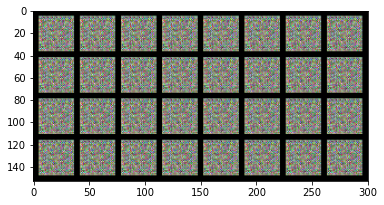

In [29]:
plt.imshow(np.transpose(vutils.make_grid(fake_imgs.to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))


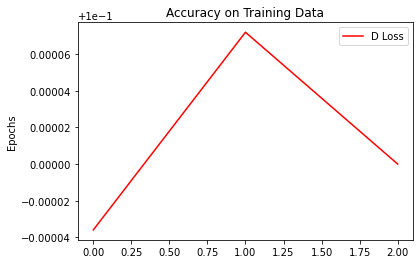

In [37]:
plt.plot(myac, 'r' , label = "D Loss") # plotting t, a separately 
plt.ylabel("Epochs")
plt.title('Accuracy on Training Data')
plt.legend()
plt.show()


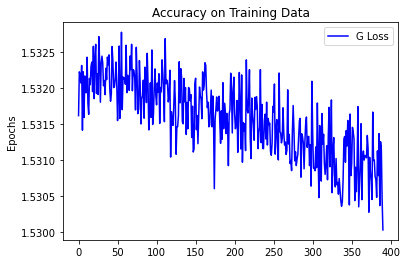

In [39]:
plt.plot(d_err, 'b' , label = "G Loss") # plotting t, b separately 
plt.ylabel("Epochs")
plt.title('Accuracy on Training Data')
plt.legend()
plt.show()
  

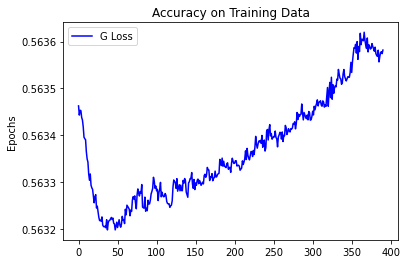

In [40]:
plt.plot(g_err, 'b' , label = "G Loss") # plotting t, b separately 
plt.ylabel("Epochs")
plt.title('Accuracy on Training Data')
plt.legend()
plt.show()
 